# BLM example

In [1]:
# Add PyTwoWay to system path, do not run this
# import sys
# sys.path.append('../../..')

In [2]:
# Import the PyTwoWay package 
# (Make sure you have installed it using pip install pytwoway)
import pytwoway as tw
from matplotlib import pyplot as plt

## Simulate some data

The package contains functions to simulate data. We use this here to keep things simple.

In [3]:
# For the example, we simulate data
# Set parameter choices
nl = 2 # Number of worker types
nk = 3 # Number of firm types
fsize = 10 # Max number of employees at a firm
mmult = 100 # Increase observations for movers x100
smult = 100 # Increase observations for stayers x100
blm_true = tw.BLMModel({
    'nl': nl, # Number of worker types
    'nk': nk, # Number of firm types
    'simulation': True # Simulating data
})
sim_data = blm_true._m2_mixt_simulate_sim(fsize=fsize, mmult=mmult, smult=smult)
display(sim_data['jdata'])
display(sim_data['sdata'])

,l,y1,y2,g1,g2,g1true,g2true,j1,j2
0,0,-0.204997,0.162597,0,0,0,0,F79,F62
1,0,0.596359,0.145901,0,0,0,0,F94,F22
2,0,0.241762,-0.436507,0,0,0,0,F45,F55
3,0,-0.267093,-0.465321,0,0,0,0,F77,F94
4,0,-0.433961,0.453097,0,0,0,0,F10,F23
...,...,...,...,...,...,...,...,...,...
8995,1,1.442152,2.486254,2,2,2,2,F2,F97
8996,1,1.033829,1.805655,2,2,2,2,F86,F88
8997,1,1.520521,2.104295,2,2,2,2,F92,F101
8998,1,0.531664,2.451577,2,2,2,2,F16,F53


,k,y1,y2,g1,g2,x,j1,g1true,j2
0,0,0.748584,0.640799,0,0,1,F60,0,F60
1,1,0.563338,1.085478,0,0,1,F1,0,F1
2,1,0.144916,1.039482,0,0,1,F24,0,F24
3,1,0.800272,0.715033,0,0,1,F50,0,F50
4,0,0.191230,0.791316,0,0,1,F47,0,F47
...,...,...,...,...,...,...,...,...,...
2995,0,1.280293,0.516505,2,2,1,F14,2,F14
2996,0,0.380551,1.293276,2,2,1,F44,2,F44
2997,0,1.653189,1.368964,2,2,1,F4,2,F4
2998,0,1.770214,1.727462,2,2,1,F15,2,F15


## Initialize and run BLMEstimator

In [4]:
## Optional Parameters ##
user_blm = {
    # Class parameters
    'nl': nl, # Number of worker types
    'nk': nk, # Number of firm types
    'fixb': False, # Set A2 = np.mean(A2, axis=0) + A1 - np.mean(A1, axis=0)
    'stationary': False, # Set A1 = A2
    # fit() parameters
    'n_iters': 100, # Max number of iterations
    'threshold': 1e-7, # Threshold to break EM loop
    'd_prior': 1.0001, # Value >= 1, account for probabilities being too small
    'verbose': 0, # If 0, print no output; if 1, print additional output; if 2, print maximum output
}
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(user_blm)
# Fit BLM estimator
blm_fit.fit(jdata=sim_data['jdata'], sdata=sim_data['sdata'], n_init=20, n_best=5, ncore=4)

100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


## Finally, we can investigate the results

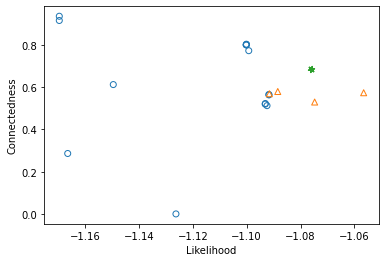

In [5]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

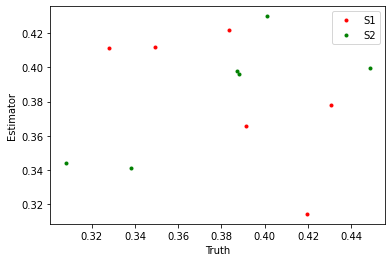

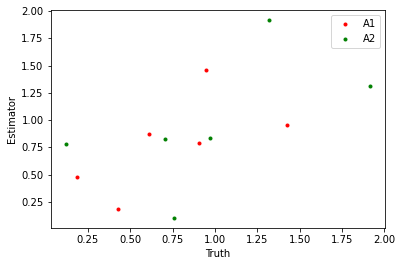

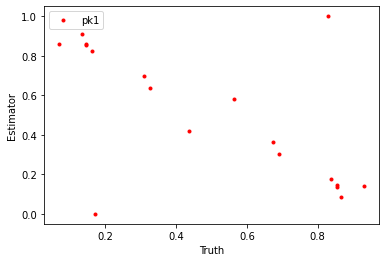

In [6]:
# Plot parameter truth vs. estimates
plt.plot(blm_true.S1.flatten(), blm_fit.model.S1.flatten(), '.', label='S1', color='red')
plt.plot(blm_true.S2.flatten(), blm_fit.model.S2.flatten(), '.', label='S2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimator')
plt.legend()
plt.show()

plt.plot(blm_true.A1.flatten(), blm_fit.model.A1.flatten(), '.', label='A1', color='red')
plt.plot(blm_true.A2.flatten(), blm_fit.model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimator')
plt.legend()
plt.show()

plt.plot(blm_true.pk1.flatten(), blm_fit.model.pk1.flatten(), '.', label='pk1', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimator')
plt.legend()
plt.show()